# 1. Importing Libraries

In [1]:
#Basic Mathematical Operations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score

from mlxtend.classifier import StackingClassifier

import lightgbm as lgb
import xgboost as xgb


#deep learning
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, GlobalMaxPool1D
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional,Flatten,LSTM
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.utils import to_categorical

#nlp
import nltk
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec


Using TensorFlow backend.
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_json('train1.json')
test = pd.read_json('test1.json')

In [3]:
df.head()

,label,text
0,MISC,although the internet as level topology has be...
1,MISC,an as node can represent a wide variety of org...
2,AIMX,in this paper we introduce a radically new app...
3,OWNX,we successfully classify number number percent...
4,OWNX,we release to the community the as level topol...


# Preprocessing

In [4]:
#Conating two dataframes 
frames = [df, test]
data = pd.concat(frames)

In [5]:
df.shape

(2864, 2)

In [6]:
test.shape

(700, 2)

In [7]:
data.shape

(3564, 2)

In [8]:
df['label'].value_counts()

MISC                   1622
OWNX                    807
AIMX                    179
CONT                    166
BASE                     60
MISC--the                 6
AIMX--on                  4
MISC--in                  4
CONT--these               2
OWNX                      2
OWNX--after               2
OWNX--we                  2
MISC--several             2
MISC--specifically,       2
MISC--for                 2
MISC--on                  2
Name: label, dtype: int64

In [9]:
#There are duplicate values like 'MISC--the' which is similar to 'MISC' in the labels
#replacing all the duplicate values

replacements = {
   'label': {
       
     
      r'MISC--the': 'MISC',
      r'MISC--specifically': 'MISC',
      r'MISC--for': 'MISC',
      r'MISC,': 'MISC',
      r'MISC--on': 'MISC',
      r'MISC--several': 'MISC',
      r'MISC--in': 'MISC',
      r'OWNX--we': 'OWNX',
      r'OWNX--after': 'OWNX',
      r'CONT--these': 'CONT',
      r'AIMX--on': 'AIMX',       
      
   }
}

data.replace(replacements, regex=True, inplace=True)

# Text Processing

In [10]:
#We use label encoding for converting the labels to numeric values
le = preprocessing.LabelEncoder()
le.fit(data['label'])
data['label'] = le.transform(data['label'])

In [11]:
data['label'].value_counts()

3    2129
4     967
0     215
2     183
1      67
5       3
Name: label, dtype: int64

In [12]:
#dealing with the text data
data['text'].iloc[0]

'although the internet as level topology has been extensively studied over the past few years little is known about the details of the as taxonomy '

In [13]:
#The text is totally in English so we dont have to convert anything 
data['text'].iloc[10]

'statistical information that faithfully characterizes different as types is on the critical path toward understanding the structure of the internet as well as for modeling its topology and growth '

In [14]:
#Counting the length of characters 
count = data['text'].apply(lambda x : len(str(x).split(' ')))


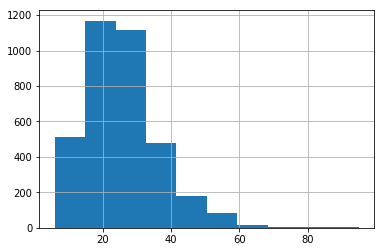

In [15]:
count.hist()

# Tokenizing and Lemmatizing

In [16]:
data['text'].iloc[0]

'although the internet as level topology has been extensively studied over the past few years little is known about the details of the as taxonomy '

In [17]:
#Here I am using WhiteSpace Tokenizer along with the WorldNet Lemmatizer in nltk
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, 'v') for w in w_tokenizer.tokenize(text)]

data['text'] = data.text.apply(lemmatize_text)


In [18]:
X_stem = data['text']

In [19]:
data['text'].iloc[0]

['although',
 'the',
 'internet',
 'as',
 'level',
 'topology',
 'have',
 'be',
 'extensively',
 'study',
 'over',
 'the',
 'past',
 'few',
 'years',
 'little',
 'be',
 'know',
 'about',
 'the',
 'detail',
 'of',
 'the',
 'as',
 'taxonomy']

# Stopword Removal

In [20]:
#Stop word removal
#Here I am using the stop words proposed in the given data.

stop = ['of','a','and','the','in','to','for','that','is','on','are','with','as',
        'by','be','an','which','it','from','or','can','have','these','has','such','we']

#removes all the stop words
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))

In [21]:
data['text'].iloc[2]

'this paper introduce radically new approach base machine learn techniques map all ases internet into natural taxonomy'

Splitting into train and test sets

In [22]:
data.columns

Index(['label', 'text'], dtype='object')

In [23]:
X = data['text'].copy()
y = data['label'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#  TFIDF

Machine learning or Deep learning models will not accept the text data directly so we have to convert it into numeric
or vectors. There are some techniques like TFIDF, Glove Vector, Raw Character label encoding, Fast Text vectors by Facebook.


In [24]:
#TFIDF model gives the inverse logarthmic weight to every word 
tfidf = TfidfVectorizer(stop_words=stop, max_features=800000)
#Only training data need to fit through the TFIDF because by doing fit the model learns and it is applied while transform
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [25]:
print(X_train_tfidf[0:,:1])

  (2213, 0)	0.47536796671459186


#  GloVe Vectors

In [26]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.txt' #input file for glove embeddings
word2vec_output_file = 'word2vec.txt' #input file for word2vec
glove2word2vec(glove_input_file, word2vec_output_file)

(9, 13)

In [27]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt' #pretrained GloVe Model
word2vec_output_file = 'glove.6B.100d.txt.word2vec' #Saving word2vec file
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

In [28]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)


# Tokenizer Class

In [29]:
#Using Keras built in tokenizer for word embeddings
from keras.preprocessing.text import Tokenizer
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(X_train)


In [30]:
maxlen = 150 #Max number of features in the sequence
X_train_encoded = t.texts_to_sequences(X_train) #converts text into sequence using keras text tokenizer
X_test_encoded = t.texts_to_sequences(X_test)

For deep learning models the sequences should be of same length, so for making it to same length the sequences should be padded to a certain length. By using the pad_sequences it can be done.

In [31]:
X_train_padded = pad_sequences(X_train_encoded, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_encoded, maxlen=maxlen) #pad sequences to a maxlen of 150 words

# Classification

# LinearSVC

In [32]:
#First lets try the Basic ML algorithm
#Linear Support Vector Classifier is used here
#TFIDF preprocessed sparce vectors are used here

from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=67, C= 5,multi_class = 'ovr')
clf.fit(X_train_tfidf, y_train)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=67, tol=0.0001,
     verbose=0)

In [33]:
clf.predict(X_test_tfidf)

array([3, 4, 3, 2, 3, 3, 4, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 4, 1, 4, 4, 4,
       3, 4, 0, 3, 4, 1, 3, 3, 4, 4, 0, 3, 2, 4, 4, 4, 4, 3, 4, 3, 4, 3,
       0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 2, 3, 2, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4, 2,
       4, 3, 0, 4, 2, 3, 0, 3, 3, 3, 3, 3, 4, 4, 4, 3, 2, 3, 4, 3, 4, 4,
       3, 4, 3, 0, 3, 2, 4, 3, 3, 3, 3, 4, 3, 3, 4, 0, 3, 3, 0, 0, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 3, 1, 3, 4, 2, 3, 4,
       4, 4, 3, 3, 4, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 0, 3, 3, 4, 3, 2, 4,
       3, 1, 3, 4, 3, 3, 4, 0, 4, 3, 0, 4, 3, 3, 3, 0, 3, 3, 0, 2, 3, 3,
       3, 4, 3, 4, 3, 3, 4, 4, 3, 4, 3, 3, 4, 3, 3, 3, 0, 3, 3, 4, 3, 3,
       3, 4, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 4, 0, 3, 4, 3, 0, 3, 3, 3,
       4, 4, 4, 4, 4, 3, 0, 3, 2, 4, 3, 4, 3, 4, 3,

In [34]:
clf.score(X_test_tfidf, y_test)

0.8541374474053296

So, with the basic Support Vector Classifier the accuracy is around 85%. The accuracy can be increased by using deep learning algorithms and by using Ensembls.

Basic Deep learning algorithm

#  Embedding keras

In [35]:
#as the sequential model in keras doesnt support Sparce matrix so we are converting it to array
X_train_tfidf_array = X_train_tfidf.toarray()
X_test_tfidf_array = X_test_tfidf.toarray()

In [36]:
vocab_size = 50

In [37]:
MAX_LENGTH = 3263 #max len of the elements in the array
num_class = 6    #total number of categorical values

inputs = Input(shape=(MAX_LENGTH, ))  #input layer 
embedding_layer = Embedding(vocab_size,128,input_length=MAX_LENGTH)(inputs) #Embedding layer 
x = Flatten()(embedding_layer)
x = Dense(32, activation='relu')(x)

predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(X_train_tfidf_array, batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=20)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 2138 samples, validate on 713 samples
Epoch 1/20
2138/2138 [==============================] - 22s 11ms/step - loss: 2.6778 - acc: 0.5529 - val_loss: 2.2275 - val_acc: 0.6311
Epoch 2/20
2138/2138 [==============================] - 23s 11ms/step - loss: 2.4445 - acc: 0.5940 - val_loss: 2.2280 - val_acc: 0.6311
Epoch 3/20
2138/2138 [==============================] - 24s 11ms/step - loss: 1.9992 - acc: 0.5800 - val_loss: 1.5054 - val_acc: 0.6311
Epoch 4/20
2138/2138 [==============================] - 24s 11ms/step - loss: 1.1832 - acc: 0.5978 - val_loss: 1.0029 - val_acc: 0.6311
Epoch 5/20
2138/2138 [==============================] - 22s 10ms/step - loss: 1.0791 - acc: 0.5978 - val_loss: 0.9846 - val_acc: 0.6311
Epoch 6/20
2138/2138 [==============================] 

In [38]:
inputs = Input(shape=(MAX_LENGTH, ))
embedding_layer = Embedding(vocab_size,128,input_length=MAX_LENGTH)(inputs)

x = LSTM(64)(embedding_layer)
x = Dense(32, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)
model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

'''
model.fit(X_train_tfidf_array, batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=5)
          '''

'\nmodel.fit(X_train_tfidf_array, batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, \n          shuffle=True, epochs=5)\n          '

This part of code is using embedding layer along with LSTM, due to complexity in the layers it is taking a long time.

# Ensembling Models

In ensembling I will start with simple ensemble models like Adaboost, Gradient boost, Extra features.

# Simple Stacked Classification

In [39]:
clf1 =  KNeighborsClassifier(n_neighbors=1) #K Nearest Neighbours in Sklearn
clf2 =  RandomForestClassifier(random_state=42) #Random forest Classifier
#clf3 = MultinomialNB()  #Gaussian Naive Bayes
clf3 =  LinearSVC(random_state=67, C= 5,multi_class = 'ovr') #Linear SVC
clf4 =  GradientBoostingClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression() #Logestic Regression

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)
for clf, label in zip([clf1, clf2, clf3,clf4, sclf], 
                      ['KNN', 
                       'Random Forest', 
                       'LinearSVC',
                       'GB',
                       'StackingClassifier']):
    scores = model_selection.cross_val_score(clf, X_train_tfidf, y_train, 
                                              cv=3, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.83 (+/- 0.01) [KNN]
Accuracy: 0.83 (+/- 0.01) [Random Forest]


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.84 (+/- 0.01) [LinearSVC]


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.82 (+/- 0.01) [GB]


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.83 (+/- 0.01) [StackingClassifier]


# Adaboost

In [40]:

bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
bdt.fit(X_train_tfidf, y_train)
bdt.predict(X_test_tfidf)
bdt.score(X_test_tfidf, y_test)

0.6479663394109397

# Lightgbm

In [41]:
parameters = {
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}
#For Light gbm the trainig data should in form of Dataset
#Converting the X_train to the lgb Dataset
train_data = lgb.Dataset(X_train_tfidf, label=y_train)
test_data = lgb.Dataset(X_test_tfidf, label=y_test)

model = lgb.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)
y = model.predict(X_test_tfidf)

[1]	valid_0's auc: 0.672306
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.771608
[3]	valid_0's auc: 0.781501
[4]	valid_0's auc: 0.787331
[5]	valid_0's auc: 0.813492
[6]	valid_0's auc: 0.81727
[7]	valid_0's auc: 0.809578
[8]	valid_0's auc: 0.808885
[9]	valid_0's auc: 0.812554
[10]	valid_0's auc: 0.813451
[11]	valid_0's auc: 0.817121
[12]	valid_0's auc: 0.813329
[13]	valid_0's auc: 0.817542
[14]	valid_0's auc: 0.825696
[15]	valid_0's auc: 0.828169
[16]	valid_0's auc: 0.831784
[17]	valid_0's auc: 0.829501
[18]	valid_0's auc: 0.832572
[19]	valid_0's auc: 0.831784
[20]	valid_0's auc: 0.833659
[21]	valid_0's auc: 0.834448
[22]	valid_0's auc: 0.837302
[23]	valid_0's auc: 0.843009
[24]	valid_0's auc: 0.843743
[25]	valid_0's auc: 0.842194
[26]	valid_0's auc: 0.843037
[27]	valid_0's auc: 0.842901
[28]	valid_0's auc: 0.84108
[29]	valid_0's auc: 0.840781
[30]	valid_0's auc: 0.84108
[31]	valid_0's auc: 0.840291
[32]	valid_0's auc: 0.840454
[33]	valid_0's auc: 0

[278]	valid_0's auc: 0.887177
[279]	valid_0's auc: 0.887503
[280]	valid_0's auc: 0.887611
[281]	valid_0's auc: 0.887503
[282]	valid_0's auc: 0.888128
[283]	valid_0's auc: 0.888101
[284]	valid_0's auc: 0.888345
[285]	valid_0's auc: 0.888508
[286]	valid_0's auc: 0.888726
[287]	valid_0's auc: 0.889215
[288]	valid_0's auc: 0.889079
[289]	valid_0's auc: 0.889351
[290]	valid_0's auc: 0.889351
[291]	valid_0's auc: 0.889867
[292]	valid_0's auc: 0.890058
[293]	valid_0's auc: 0.890492
[294]	valid_0's auc: 0.891118
[295]	valid_0's auc: 0.891063
[296]	valid_0's auc: 0.89158
[297]	valid_0's auc: 0.891634
[298]	valid_0's auc: 0.891906
[299]	valid_0's auc: 0.892232
[300]	valid_0's auc: 0.892368
[301]	valid_0's auc: 0.892531
[302]	valid_0's auc: 0.892694
[303]	valid_0's auc: 0.892776
[304]	valid_0's auc: 0.893075
[305]	valid_0's auc: 0.893509
[306]	valid_0's auc: 0.893863
[307]	valid_0's auc: 0.894026
[308]	valid_0's auc: 0.894243
[309]	valid_0's auc: 0.894651
[310]	valid_0's auc: 0.894814
[311]	valid

[584]	valid_0's auc: 0.908322
[585]	valid_0's auc: 0.908295
[586]	valid_0's auc: 0.907942
[587]	valid_0's auc: 0.907833
[588]	valid_0's auc: 0.907643
[589]	valid_0's auc: 0.907371
[590]	valid_0's auc: 0.907371
[591]	valid_0's auc: 0.907072
[592]	valid_0's auc: 0.906991
[593]	valid_0's auc: 0.906637
[594]	valid_0's auc: 0.906447
[595]	valid_0's auc: 0.906284
[596]	valid_0's auc: 0.906012
[597]	valid_0's auc: 0.905577
[598]	valid_0's auc: 0.905604
[599]	valid_0's auc: 0.905523
[600]	valid_0's auc: 0.905142
[601]	valid_0's auc: 0.905686
[602]	valid_0's auc: 0.905876
[603]	valid_0's auc: 0.906583
[604]	valid_0's auc: 0.906882
[605]	valid_0's auc: 0.907697
[606]	valid_0's auc: 0.907996
[607]	valid_0's auc: 0.908513
[608]	valid_0's auc: 0.908948
[609]	valid_0's auc: 0.908866
[610]	valid_0's auc: 0.909274
[611]	valid_0's auc: 0.909165
[612]	valid_0's auc: 0.90941
[613]	valid_0's auc: 0.908893
[614]	valid_0's auc: 0.908812
[615]	valid_0's auc: 0.909247
[616]	valid_0's auc: 0.909573
[617]	valid

In [76]:
print(y)

[ 3.74953402  3.29126042  3.14771065  2.34534736  3.13987713  3.07850488
  2.31425661  2.96573642  2.97148446  2.26511346  2.68866328  2.75684235
  2.98144417  3.15683004  2.77503991  3.06366156  2.96058965  3.47460267
  1.34544329  3.6009856   3.89762438  3.74465329  3.32926776  3.95418001
  1.46308046  2.09871987  3.72370511  2.35643472  2.94553256  2.86771996
  3.90194749  4.01510893  0.07565199  3.01824617  2.93057589  2.38267478
  3.42628882  4.05494693  2.55089139  2.93135859  3.95773359  2.9503273
  3.82104972  2.92345155  1.25183337  2.93380266  3.06692387  2.95443086
  3.01479051  3.06700929  3.04857808  3.23424693  2.83481234  3.00961421
  2.93448883  3.43049562  3.07487976  2.88714701  3.52453006  3.17252758
  2.86696662  3.98692234  2.90222934  2.91549017  2.92981271  3.32622525
  3.82213316  3.50809254  3.49363674  3.02947528  3.41908682  3.36543407
  2.77107834  2.97049226  2.98025328  2.8296077   2.77884915  2.41313374
  3.76868538  2.99836634  2.94923839  3.38794529  3.

Best Model Sofar with an validation accuracy of 91%

# XGBoost

In [42]:

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train_tfidf, y_train)
predictions = gbm.predict(X_test_tfidf)
print(accuracy_score(y_test, predictions))
#xgb.Score(X_test_tfidf, y_test_tfidf)

0.8022440392706872


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Deep Learning Models

# LSTM + Glove Method

In [51]:
#This part of the code is inspired from fellow kaggler from:
# 'https://www.kaggle.com/demesgal/lstm-glove-lr-decrease-bn-cv-lb-0-047 '

EMBEDDING_FILE='glove.6B.50d.txt'

embed_size = 50 # how big is each word vector
max_features = 3330 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 150 # max number of words in a comment to use


#using the pretrained glove word2vec embedded values 
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32') #reading the glove word in the vector form from pretrained model
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE,encoding="utf8"))

#By using these vectors we have to create the matrix 

all_embs = np.stack(embeddings_index.values()) #joining the sequence
emb_mean,emb_std = all_embs.mean(), all_embs.std() #Embedding Mean and Strandard deviation

word_index = t.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector



In [73]:
#Bidirectional LSTM with half sized embedding with two fully connected layers

inp = Input(shape=(maxlen,)) #input layer
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=True)(inp) #Embedding layer
x = Bidirectional(LSTM(50, return_sequences=True,dropout=0.1, recurrent_dropout=0.1))(x) #Bidirectional LSTM
x = GlobalMaxPool1D()(x)  #MAX Pooling 
x = BatchNormalization()(x) #Batch Normalization
x = Dense(50, activation="relu")(x) 
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])


In [74]:
model.fit(X_train_padded, y_train, batch_size=64, epochs=30) #,validation_data=(X_test_padded, y_test)

Epoch 1/30
2851/2851 [==============================] - 23s 8ms/step - loss: 1.3358 - acc: 0.4904
Epoch 2/30
2851/2851 [==============================] - 17s 6ms/step - loss: 0.9167 - acc: 0.6398
Epoch 3/30
2851/2851 [==============================] - 19s 7ms/step - loss: 0.7172 - acc: 0.7155
Epoch 4/30
2851/2851 [==============================] - 21s 7ms/step - loss: 0.5381 - acc: 0.7938
Epoch 5/30
2851/2851 [==============================] - 17s 6ms/step - loss: 0.4124 - acc: 0.8502
Epoch 6/30
2851/2851 [==============================] - 17s 6ms/step - loss: 0.3370 - acc: 0.8786
Epoch 7/30
2851/2851 [==============================] - 17s 6ms/step - loss: 0.3014 - acc: 0.8839
Epoch 8/30
2851/2851 [==============================] - 17s 6ms/step - loss: 0.2651 - acc: 0.8920
Epoch 9/30
2851/2851 [==============================] - 17s 6ms/step - loss: 0.2479 - acc: 0.9000
Epoch 10/30
2851/2851 [==============================] - 16s 6ms/step - loss: 0.2277 - acc: 0.8986
Epoch 11/30
2851/28

The Bidirectional LSTM along with the Glove Embedding vectors gives an accuracy of 91%. This is the best accuracy so far followed by the LightBGM.


Thank you :)